In [79]:
import os
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras
import tensorflow as tf
import cv2

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
import pickle

In [80]:
labels_path = "./data/labels2"
images_data_path = "./data/images2"

In [81]:
def create_df():
    data = {
        'image_id' : [],
        'labels':[]
    }
    for filename in os.listdir(images_data_path):
        data['image_id'].append(filename)
        
        label_file = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(labels_path, label_file)

        with open(label_path, 'r') as f:
            label_data = f.readlines()
        
        label = []
        for line in label_data:
            parts = line.split()
            x_min, y_min, x_max, y_max = map(float, parts[2:])
            label.append([x_min, y_min, x_max, y_max])
        data['labels'].append(label)
    df = pd.DataFrame(data)
    
    return df

In [82]:
df = create_df()
df.head()

,image_id,labels
0,00006c07d2b033d1.jpg,"[[332.8, 235.199488, 475.200512, 432.0], [609...."
1,0000bee39176697a.jpg,"[[186.24, 249.80592399999998, 266.24, 354.8530..."
2,0000eda1171fe14e.jpg,"[[81.28, 363.595016, 106.88, 388.560724], [400..."
3,0003d5dfa8f0dd41.jpg,"[[152.96, 53.119872, 251.52, 125.440128], [376..."
4,0007ad5c6245a41d.jpg,"[[165.12, 178.11820400000002, 463.36, 584.9710..."


In [83]:
def plotting_image_with_box(index):

    test_image = cv2.imread(images_data_path + "/" + df["image_id"][index])
    points_list = df["labels"][index]

    fig, ax = plt.subplots()

    for points in points_list:
        xtl, ytl, xbr, ybr = points[0], points[1], points[2], points[3]

        rect = patches.Rectangle((xtl, ytl), xbr - xtl, ybr - ytl, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(test_image)


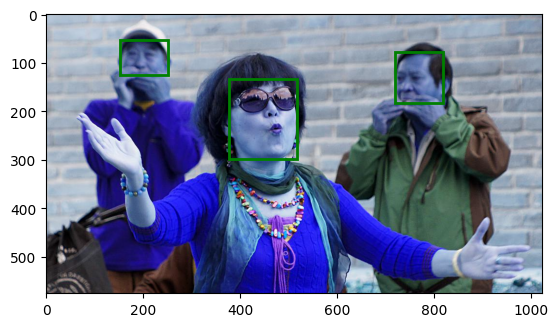

In [84]:
plotting_image_with_box(3)

In [85]:
def load_data(images_path, labels_path):
    images = []
    labels = []
    for filename in os.listdir(images_path):
        img_path = os.path.join(images_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        original_height, original_width = img.shape[:2]

        img  =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  
        
        x_scale = 244 / original_width
        y_scale = 244 / original_height

        label_file = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(labels_path, label_file)
        
        with open(label_path, 'r') as f:
            label_data = f.readlines()
        label = []
        for line in label_data:
            parts = line.split()
            x_min, y_min, x_max, y_max = map(float, parts[2:])
            x_min_resized = x_min * x_scale
            y_min_resized = y_min * y_scale
            x_max_resized = x_max * x_scale
            y_max_resized = y_max * y_scale
            if len(label) < 5:
                label.append([x_min_resized, y_min_resized, x_max_resized, y_max_resized])
        
        images.append(img)
        while len(label) < 5:
            label.append([0,0,0,0])
        labels.append(label)
    X = np.array(images)
    Y = np.array(labels, dtype=np.float32) 
    Y = Y.reshape((len(Y), 5 * 4))
    return X,Y 

In [86]:
X, y = load_data(images_data_path, labels_path)
print(y[0])

[ 79.3      56.04363 113.23137 102.9375  145.25613  54.1375  179.95
 100.26863   0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.     ]


In [87]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.17,random_state = 42)

In [92]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(224,224,3)))
model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))


In [93]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,260 (3.18 MB)

 Trainable params: 833,260 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [95]:
training_process = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=300, shuffle=True)

Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.0192 - loss: 6599.3320 - val_accuracy: 0.0000e+00 - val_loss: 5780.7847
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.1002 - loss: 5110.2158 - val_accuracy: 0.2105 - val_loss: 5619.0537
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.1425 - loss: 4513.6655 - val_accuracy: 0.2105 - val_loss: 5272.2427
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.1823 - loss: 4071.5239 - val_accuracy: 0.2105 - val_loss: 5015.9082
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.2067 - loss: 3815.1562 - val_accuracy: 0.2105 - val_loss: 4863.4775
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2089 - loss: 3740.9692 - val_accuracy: 0.2109 - val_loss: 5125.7095
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.2188 - loss: 3609.8887 - val_accuracy: 0.2105 - val_loss: 4798.6953
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accura

KeyboardInterrupt: 

In [ ]:
with open('02Model.pkl', 'wb') as f:
    pickle.dump(model, f)